In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import scipy.signal as sg
import scipy.optimize as opt

from scipy.signal import butter, filtfilt, find_peaks
import heartpy as hp

from pathlib import Path

plt.rcParams['figure.figsize'] = (16, 6)

In [165]:
# От 1 до 22
subject_no = 6
trial_no = 5

subject_no = f'00{subject_no}' if (subject_no < 10) else f'0{subject_no}'

path_raw = Path.cwd() / 'MAUS' / 'Data' / 'Raw_data' / subject_no

# list(path_raw.iterdir())

In [166]:
df_ppg_finger_trial = pd.read_csv(path_raw / 'inf_ppg.csv')
# df_ppg_finger_trial.head()
ppg_example_finger = df_ppg_finger_trial[df_ppg_finger_trial.columns[trial_no-1]]

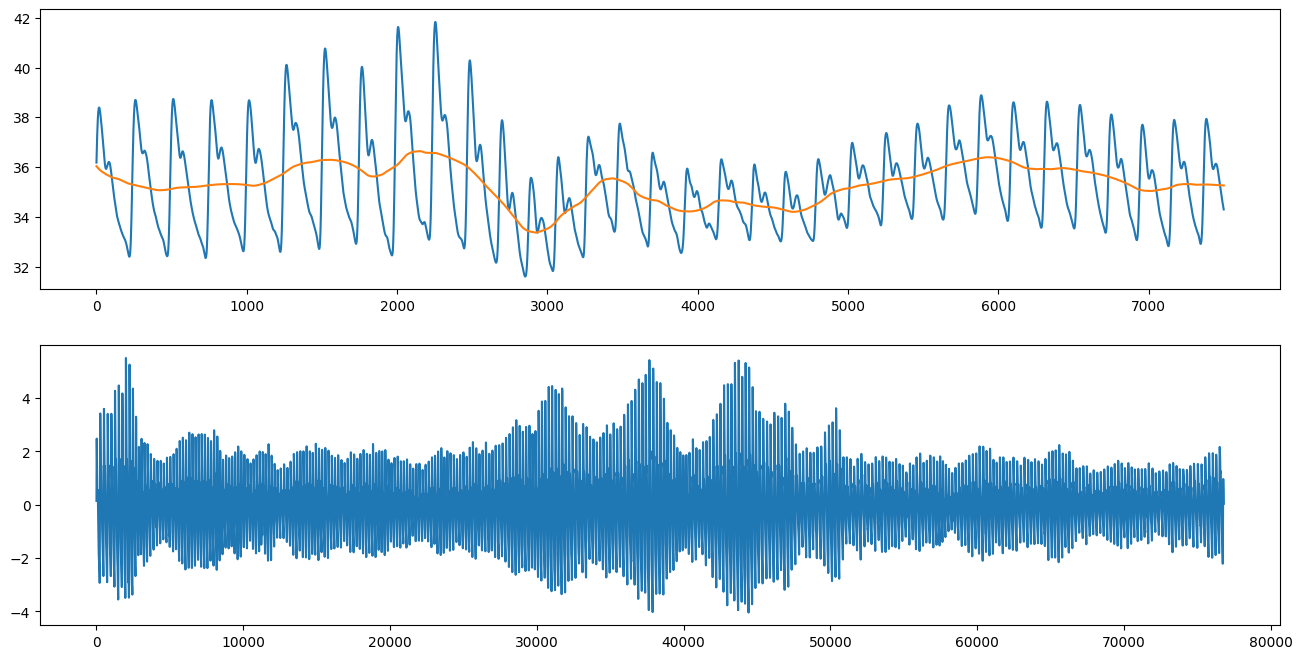

In [167]:
def denoise_ppg(ppg_signal, wavelet='db2', level=2, threshold_factor=1.5):
    """
    Фильтрация PPG-сигнала с помощью вейвлета Дебоши.
    :param ppg_signal: Исходный PPG-сигнал (numpy array)
    :param wavelet: Тип вейвлета (по умолчанию 'db4')
    :param level: Уровень разложения вейвлета (по умолчанию 5)
    :param threshold_factor: Коэффициент порога для удаления шумов
    :return: Очищенный PPG-сигнал
    """
    # Вейвлет-разложение
    coeffs = pywt.wavedec(ppg_signal, wavelet, level=level)
    # Вычисляем порог (адаптивный, на основе энергии коэффициентов)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = threshold_factor * sigma
    # Применяем мягкое пороговое значение (удаляем шумовые пики)
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    # Обратное вейвлет-преобразование
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet)
    # Приводим размер к оригинальному (иногда waverec добавляет пару лишних точек)
    denoised_signal = denoised_signal[:len(ppg_signal)]
    
    return denoised_signal


def remove_parasitic_peak(ppg_signal, wavelet='db4', level=8):

    coeffs = pywt.wavedec(ppg_signal, wavelet, level=level)

    coeffs_filtered = [coeffs[0]]  # Оставляем только приближающие коэффициенты
    for i in range(1, len(coeffs)):
        coeffs_filtered.append(np.zeros_like(coeffs[i]))

    cleaned_signal = pywt.waverec(coeffs_filtered, wavelet)
    cleaned_signal = cleaned_signal[:len(ppg_signal)]

    return cleaned_signal


ppg_denoised = remove_parasitic_peak(ppg_example_finger)

plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.plot(ppg_example_finger[0:int(len(ppg_example_finger) / 256*25)])
plt.plot(ppg_denoised[0:int(len(ppg_example_finger) / 256*25)])
plt.subplot(212)
plt.plot(ppg_example_finger - ppg_denoised)
# plt.subplot(313)
# plt.plot(ppg_denoised)
plt.show()

### Нахождение H-(al)-F и L-(i)-F-(e) параметров и их отношение друг с другом. 

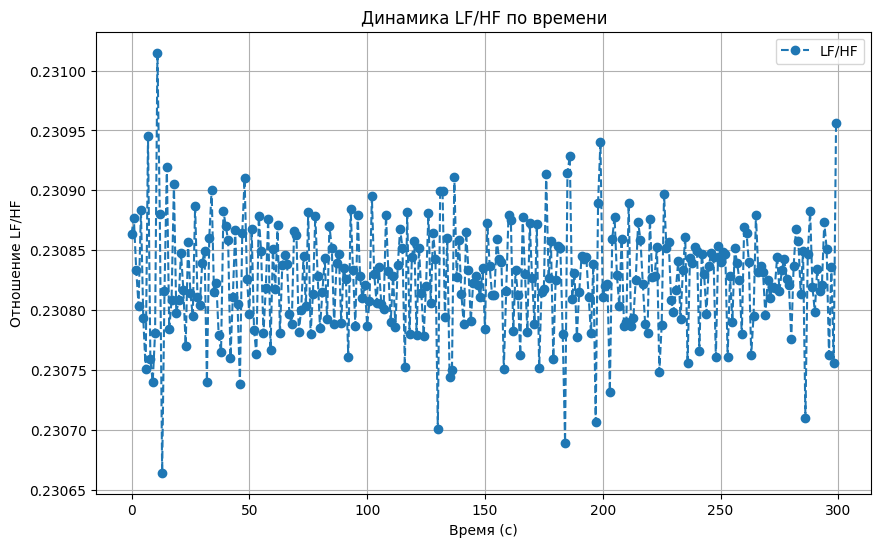

Среднее отношение LF/HF: 0.231


In [168]:
def wavelet_cwt_analysis(ppg_signal, fs=256, wavelet='morl'):
    # Определяем частоты в диапазоне 0.04–0.4 Гц
    freqs = np.linspace(0.04, 0.4, 50)  # 50 частот
    scales = pywt.frequency2scale(wavelet, freqs / fs)  # Конвертируем частоты в масштабы

    num_windows = len(ppg_signal) // fs  # Количество окон
    lf_power_list, hf_power_list = [], []

    for i in range(num_windows):
        window = ppg_signal[i * fs: (i + 1) * fs]  # Берём окно размером fs
        coeffs, _ = pywt.cwt(window, scales, wavelet)  # CWT только для окна

        # Вычисляем энергию LF и HF в этом окне
        lf_idx = np.where((freqs >= 0.04) & (freqs <= 0.15))[0]
        hf_idx = np.where((freqs >= 0.15) & (freqs <= 0.4))[0]

        lf_power = np.sum(np.abs(coeffs[lf_idx, :]) ** 2)
        hf_power = np.sum(np.abs(coeffs[hf_idx, :]) ** 2)

        lf_power_list.append(lf_power)
        hf_power_list.append(hf_power)

    lf_power_arr = np.array(lf_power_list)
    hf_power_arr = np.array(hf_power_list)
    
    # Отношение LF/HF
    lf_hf_ratio = lf_power_arr / hf_power_arr
    time_axis = np.arange(num_windows)  # Ось времени

    return lf_hf_ratio, lf_power_arr, hf_power_arr, time_axis

# === Пример использования ===
fs = 256  # Частота дискретизации PPG
lf_hf, lf_signal, hf_signal, time_axis = wavelet_cwt_analysis(ppg_denoised, fs)

# === Визуализация ===
plt.figure(figsize=(10, 6))

# LF/HF отношение по времени
plt.plot(time_axis, lf_hf, label="LF/HF", marker="o", linestyle="--")
plt.xlabel("Время (с)")
plt.ylabel("Отношение LF/HF")
plt.title("Динамика LF/HF по времени")
plt.legend()
plt.grid()

plt.show()

print(f"Среднее отношение LF/HF: {np.mean(lf_hf):.3f}")


### Нахождение параметров вейвлетов (scale, amplitude) для HF и LF, аппроксимирующие частотные окна сигнала посредством преобразования Фурье  

In [169]:
def morlet_spectrum(frequencies, f0, s, a):
    return a * np.exp(-((frequencies - f0) ** 2) / (2 * (s ** 2)))

def loss(params, frequencies, spectrum):
    f1, s1, a1 = params
    approx = morlet_spectrum(frequencies, f1, s1, a1)
    return np.mean((spectrum - approx) ** 2)

In [170]:
# результатом служат 3 параметра:
# f - массив частот от 0 до частоты Найквиста (500 / 2 = 250 Гц)
# t_stft - временные точки центральные для каждого окна
# Zxx - матрица размером f на t_stft комплекных предствалнений спектра (амплитуды и фазового сдвига)
len_window = fs * 25
f, t_stft, Zxx = sg.stft(ppg_denoised, fs, nperseg=len_window)
spectrogram = np.abs(Zxx)  # переводим в амплитудное представление спектрограммы

f_low = np.linspace(0.04, 0.15, 50)
f_high = np.linspace(0.15, 0.4, 50)

optimal_params_low = []
optimal_params_high = []

freq_min_low = np.min(f_low)  
freq_max_low = np.max(f_low)   
freq_min_high = np.min(f_high)  
freq_max_high = np.max(f_high)   

scale_min_low = 1 / freq_max_low
scale_max_low = 1 / freq_min_low   
scale_min_high = 1 / freq_max_high
scale_max_high = 1 / freq_min_high  

amplitude_min = 0.01
amplitude_max = 1

# Границы для оптимизации
low_bounds = [
    (freq_min_low, freq_max_low),  # Частота (например, по спектру)
    (scale_min_low, scale_max_low),  # Масштаб, зависящий от частоты
    (amplitude_min, amplitude_max),  # Амплитуда
]
high_bounds = [
    (freq_min_high, freq_max_high),  # Частота (например, по спектру)
    (scale_min_high, scale_max_high),  # Масштаб, зависящий от частоты
    (amplitude_min, amplitude_max),  # Амплитуда
]

In [171]:
# цикл с колличеством итераций по колличество полученных окон
for i in range(spectrogram.shape[1]): 
    spectrum = spectrogram[:, i]  # достаем спектр из i-ого окна

    # применяем оптимизацию алгоритма дифференциальной эволюции для трех наших параметров каждого вейвлета (3х3)
    result = opt.differential_evolution(loss, low_bounds, args=(f, spectrum), strategy='best1bin')
    optimal_params_low.append(result.x)
    result = opt.differential_evolution(loss, high_bounds, args=(f, spectrum), strategy='best1bin')
    optimal_params_high.append(result.x)
    
print("Оптимизация завершена!")

low_ampl_param = []
high_ampl_param = []

for i in range(0, len(optimal_params_low)):
    low_ampl_param.append(optimal_params_low[i][2])
    # print(f'Оптимальные параметры для окна LF №{i+1} : amplitude -> {optimal_params_low[i][2]};\n')

for i in range(0, len(optimal_params_high)):
    high_ampl_param.append(optimal_params_high[i][2])
    # print(f'Оптимальные параметры для окна HF №{i+1} : amplitude -> {optimal_params_high[i][2]};\n')

Оптимизация завершена!


In [172]:
scale_min_low = 0.0001
scale_max_low = 1 
scale_min_high = 0.0001
scale_max_high = 1  

amplitude_min = 0.001

# Границы для оптимизации
low_bounds = [
    (freq_min_low, freq_max_low),  # Частота (например, по спектру)
    (scale_min_low, scale_max_low),  # Масштаб, зависящий от частоты
    (amplitude_min, amplitude_max),  # Амплитуда
]
high_bounds = [
    (freq_min_high, freq_max_high),  # Частота (например, по спектру)
    (scale_min_high, scale_max_high),  # Масштаб, зависящий от частоты
    (amplitude_min, amplitude_max),  # Амплитуда
]

In [173]:
optimal_params_low.clear()
optimal_params_high.clear()

# цикл с колличеством итераций по колличество полученных окон
for i in range(spectrogram.shape[1]): 
    spectrum = spectrogram[:, i]  # достаем спектр из i-ого окна

    # применяем оптимизацию алгоритма дифференциальной эволюции для трех наших параметров каждого вейвлета (3х3)
    result = opt.differential_evolution(loss, low_bounds, args=(f, spectrum), strategy='best1bin')
    optimal_params_low.append(result.x)
    result = opt.differential_evolution(loss, high_bounds, args=(f, spectrum), strategy='best1bin')
    optimal_params_high.append(result.x)
    
print("Оптимизация завершена!")

low_scale_param = []
high_scale_param = []

for i in range(0, len(optimal_params_low)):
    low_scale_param.append(optimal_params_low[i][1])
    # print(f'Оптимальные параметры для окна LF №{i+1} : amplitude -> {optimal_params_low[i][1]};\n')

for i in range(0, len(optimal_params_high)):
    high_scale_param.append(optimal_params_high[i][1])
    # print(f'Оптимальные параметры для окна HF №{i+1} : amplitude -> {optimal_params_high[i][1]};\n')

Оптимизация завершена!


### Результаты:

In [176]:
low_ampl_param
high_ampl_param
low_scale_param
high_scale_param

[np.float64(0.9386925352871183),
 np.float64(0.4419177691933455),
 np.float64(0.43996133311225477),
 np.float64(0.4380856252323764),
 np.float64(0.43887072978479674),
 np.float64(0.4384372833287137),
 np.float64(0.4392048366073685),
 np.float64(0.4380847346985014),
 np.float64(0.4387071435934936),
 np.float64(0.44105862946854413),
 np.float64(0.439232249179784),
 np.float64(0.44090170341209833),
 np.float64(0.4375851325911952),
 np.float64(0.44081476291155397),
 np.float64(0.4392179853599866),
 np.float64(0.4386348648146995),
 np.float64(0.4395819955530937),
 np.float64(0.4392240627944688),
 np.float64(0.4385172657293537),
 np.float64(0.43969941766881093),
 np.float64(0.4391638458644704),
 np.float64(0.43718433735179313),
 np.float64(0.4377042202078082),
 np.float64(0.44068492980890506),
 np.float64(0.9323172105743606)]

### END - тут наброски из гпт-шки

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Создаем пример сигнала (например, синусоиды с разными частотами)
fs = 1000  # Частота дискретизации (Гц)
t = np.linspace(0, 1, fs, endpoint=False)  # Временная ось (1 секунда)
signal = (np.sin(2 * np.pi * 5 * t) +  # Низкочастотная компонента (5 Гц)
          0.5 * np.sin(2 * np.pi * 50 * t) +  # Высокочастотная компонента (50 Гц)
          np.random.normal(0, 0.1, len(t)))  # Добавляем шум

# Параметры для анализа
wavelet = 'db4'  # Вейвлет Добеши 4-го порядка
levels = 6       # Количество уровней декомпозиции

# Выполняем вейвлет-преобразование
coeffs = pywt.wavedec(signal, wavelet, level=levels)

# Частотные диапазоны для LF и HF
lf_range = (0.04, 0.15)  # LF: 0.04 - 0.15 Гц
hf_range = (0.15, 0.4)   # HF: 0.15 - 0.4 Гц

# Вычисляем частотные диапазоны для каждого уровня декомпозиции
freqs = np.array([fs / (2 ** (i + 1)) for i in range(levels + 1)])

# Выделяем коэффициенты, соответствующие LF и HF
lf_coeffs = []
hf_coeffs = []

for i, coeff in enumerate(coeffs):
    if freqs[i] >= lf_range[0] and freqs[i] <= lf_range[1]:
        lf_coeffs.append(coeff)  # LF-компонента
    elif freqs[i] >= hf_range[0] and freqs[i] <= hf_range[1]:
        hf_coeffs.append(coeff)  # HF-компонента
    else:
        # Обнуляем коэффициенты вне интересующих нас диапазонов
        coeffs[i] = np.zeros_like(coeff)

# Восстанавливаем сигналы для LF и HF
lf_signal = pywt.waverec(lf_coeffs, wavelet)
hf_signal = pywt.waverec(hf_coeffs, wavelet)

# Обрезаем сигналы до исходной длины (из-за граничных эффектов)
lf_signal = lf_signal[:len(signal)]
hf_signal = hf_signal[:len(signal)]

# Визуализация
plt.figure(figsize=(12, 8))

# Исходный сигнал
plt.subplot(3, 1, 1)
plt.plot(t, signal, label='Исходный сигнал')
plt.title('Исходный сигнал')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()

# LF-компонента
plt.subplot(3, 1, 2)
plt.plot(t, lf_signal, label='LF-компонента (0.04-0.15 Гц)', color='orange')
plt.title('LF-компонента')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()

# HF-компонента
plt.subplot(3, 1, 3)
plt.plot(t, hf_signal, label='HF-компонента (0.15-0.4 Гц)', color='green')
plt.title('HF-компонента')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Загрузка PPG сигнала (например, из файла wav)
# Для демонстрации используем синтетический сигнал
# Замените это на загрузку вашего PPG сигнала
fs = 256  # Частота дискретизации
t = np.linspace(0, 10, fs * 10)  # Время 10 секунд
ppg_signal = np.sin(2 * np.pi * 1 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)  # Простой синусоидальный сигнал

# Применяем вейвлет-преобразование для анализа LF и HF
# Используем Daubechies 2 (для LF) и Daubechies 6 (для HF)
coeffs_LF = pywt.wavedec(ppg_signal, 'db2', level=5)  # Для LF используем Daubechies 2
coeffs_HF = pywt.wavedec(ppg_signal, 'db6', level=5)  # Для HF используем Daubechies 6

# Визуализация спектрограммы
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Исходный сигнал
axes[0].plot(t, ppg_signal)
axes[0].set_title('Original PPG Signal')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')

# Вейвлет-представление для LF (низкочастотных) компонент
cA_LF = coeffs_LF[0]  # Approximation coefficients (низкие частоты)
axes[1].plot(np.linspace(0, len(cA_LF) / fs, len(cA_LF)), cA_LF)
axes[1].set_title('Low-Frequency Component (LF) - Daubechies 2')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')

# Вейвлет-представление для HF (высокочастотных) компонент
cA_HF = coeffs_HF[0]  # Approximation coefficients (высокие частоты)
axes[2].plot(np.linspace(0, len(cA_HF) / fs, len(cA_HF)), cA_HF)
axes[2].set_title('High-Frequency Component (HF) - Daubechies 6')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude')

# Показать графики
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def wavelet_cwt_analysis(ppg_signal, fs=256, wavelet='morl'):
    # Определяем диапазоны частот (LF: 0.04–0.15 Гц, HF: 0.15–0.4 Гц)
    freqs = np.linspace(0.04, 0.4, 50)  # 50 частот от 0.04 до 0.4 Гц
    scales = pywt.frequency2scale(wavelet, freqs / fs)  # Конвертируем частоты в масштабы

    # CWT-анализ
    coeffs, _ = pywt.cwt(ppg_signal, scales, wavelet)

    # Приводим частоты к масштабу индексов CWT
    lf_idx = np.where((freqs >= 0.04) & (freqs <= 0.15))[0]
    hf_idx = np.where((freqs >= 0.15) & (freqs <= 0.4))[0]

    # Извлекаем низкочастотный (LF) и высокочастотный (HF) компоненты
    lf_component = np.mean(np.abs(coeffs[lf_idx, :]), axis=0)
    hf_component = np.mean(np.abs(coeffs[hf_idx, :]), axis=0)

    # Энергия сигналов
    lf_power = np.sum(lf_component ** 2)
    hf_power = np.sum(hf_component ** 2)

    # Отношение LF/HF
    lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.nan

    return lf_hf_ratio, lf_component, hf_component, coeffs, freqs

# === Пример использования ===
fs = 256  # Частота дискретизации PPG
lf_hf, lf_signal, hf_signal, coeffs, freqs = wavelet_cwt_analysis(ppg_denoised, fs)

# === Визуализация ===
plt.figure(figsize=(10, 8))

# Оригинальный PPG
plt.subplot(3, 1, 1)
plt.plot(ppg_denoised, label="Оригинальный PPG", alpha=0.75)
plt.legend()

# Спектрограмма CWT
plt.subplot(3, 1, 2)
plt.imshow(np.abs(coeffs), aspect='auto', extent=[0, len(ppg_denoised) / fs, freqs.min(), freqs.max()], cmap='jet', origin='lower')
plt.colorbar(label="Амплитуда")
plt.ylabel("Частота (Гц)")
plt.title("Вейвлет-спектрограмма CWT")

# LF и HF компоненты
plt.subplot(3, 1, 3)
plt.plot(lf_signal, label="LF (0.04-0.15 Гц)", color='green')
plt.plot(hf_signal, label="HF (0.15-0.4 Гц)", color='red', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Отношение LF/HF: {lf_hf:.3f}")

In [ ]:
# Определение диапазонов LF и HF
# lf_range = (0.04, 0.15)  # LF диапазон
# hf_range = (0.15, 0.4)   # HF диапазон

# # Нахождение индексов для LF и HF
# lf_indices = np.where((f >= lf_range[0]) & (f <= lf_range[1]))[0]
# hf_indices = np.where((f >= hf_range[0]) & (f <= hf_range[1]))[0]

# # Извлечение подмассивов для LF и HF
# lf_spectrogram = spectrogram[lf_indices, :]
# hf_spectrogram = spectrogram[hf_indices, :]

# # Вывод результатов
# print("Индексы LF:", lf_indices)
# print("Индексы HF:", hf_indices)
# print("Форма LF спектрограммы:", lf_spectrogram.shape)
# print("Форма HF спектрограммы:", hf_spectrogram.shape)